In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from pycaret.classification import * # Machine learning tools
import imblearn  # Resampling
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import CondensedNearestNeighbour 
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import ConfusionMatrixDisplay # Model evaluation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns
from sklearn.metrics import classification_report # Model evaluation report
from ipywidgets import widgets # Interactive functions
from sklearn.metrics import classification_report

In [3]:
#loading data
#df = pd.read_csv("DATA/20240812_vortex_trainning_float_formmated.csv", encoding='latin-1') 
df = pd.read_excel('./data/input_data.xlsx', engine='openpyxl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Data columns (total 67 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          1816 non-null   object 
 1   Inv. Pieza  1346 non-null   object 
 2   Site        1816 non-null   object 
 3   Contexto    1805 non-null   object 
 4   Contexto 1  0 non-null      float64
 5   Contexto 2  1 non-null      float64
 6   PK_coord    592 non-null    object 
 7   Class       1816 non-null   object 
 8   XRD_code    266 non-null    object 
 9   XRD_path    264 non-null    object 
 10  XRD 1       271 non-null    object 
 11  XRD 2       121 non-null    object 
 12  XRD 3       38 non-null     object 
 13  XRD 4       3 non-null      object 
 14  Group       268 non-null    object 
 15  Subgroup    268 non-null    object 
 16  Hey's CIM   268 non-null    object 
 17  ID_XMET     1814 non-null   object 
 18  Method      1815 non-null   object 
 19  Date XRF    1815 non-null  

In [5]:

#Some basic Feature engineering
data = df.drop(df.iloc[:, : 22], axis=1)
#Comprobamos que no hay valores faltantes
# Checking missing values
data.isnull().any().any()

False

In [6]:
#data = data.drop(['suma'], axis=1)
data['Site'] = df['Site']
data['id'] = df['ID']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      1816 non-null   float64
 1   Si      1816 non-null   float64
 2   P       1816 non-null   float64
 3   S       1816 non-null   float64
 4   Cl      1816 non-null   float64
 5   K       1816 non-null   float64
 6   Ca      1816 non-null   float64
 7   Sc      1816 non-null   float64
 8   Ti      1816 non-null   float64
 9   V       1816 non-null   float64
 10  Cr      1816 non-null   float64
 11  Mn      1816 non-null   float64
 12  Fe      1816 non-null   float64
 13  Co      1816 non-null   float64
 14  Ni      1816 non-null   float64
 15  Cu      1816 non-null   float64
 16  Zn      1816 non-null   float64
 17  Ga      1816 non-null   float64
 18  Ge      1816 non-null   float64
 19  As      1816 non-null   float64
 20  Se      1816 non-null   float64
 21  Br      1816 non-null   float64
 22  

In [7]:
# 1. Comprobar si hay duplicados
duplicados = data['id'].duplicated().sum()
print(f"Número de ids duplicados: {duplicados}")

# 2. Ver los ids duplicados (si existen)
if duplicados > 0:
    print("IDs duplicados:")
    print(data[data['id'].duplicated(keep=False)]['id'].sort_values())

# 3. Eliminar duplicados, manteniendo la primera aparición
data_sin_duplicados = data.drop_duplicates(subset='id', keep='first')

# 4. Verificar que se eliminaron los duplicados
print(f"Tamaño original de data: {data.shape}")
print(f"Tamaño de data sin duplicados: {data_sin_duplicados.shape}")

# 5. Comprobar nuevamente que no hay duplicados
duplicados_restantes = data_sin_duplicados['id'].duplicated().sum()
print(f"Número de ids duplicados restantes: {duplicados_restantes}")

# 6. Si estás satisfecho con el resultado, puedes asignar el resultado de vuelta a 'data'
data = data_sin_duplicados

# 7. Reiniciar los índices si es necesario
data.reset_index(drop=True, inplace=True)

Número de ids duplicados: 14
IDs duplicados:
1094                    G-84-218
1093                    G-84-218
1178                     G-85-80
1179                     G-85-80
392               GEOLOGICA LEON
393               GEOLOGICA LEON
394               GEOLOGICA LEON
395               GEOLOGICA LEON
396     GEOLOGICA QUINTANA MARCO
397     GEOLOGICA QUINTANA MARCO
440            PCM2/10/A/4-41-10
893            PCM2/10/A/4-41-10
441            PCM2/10/A/4-41-11
894            PCM2/10/A/4-41-11
897           PCM2/10/E/SUP-25-8
759           PCM2/10/E/SUP-25-8
672            PCM2/10/SUP-36-11
760            PCM2/10/SUP-36-11
899            PCM2/10/SUP-36-18
674            PCM2/10/SUP-36-18
900            PCM2/10/SUP-36-24
675            PCM2/10/SUP-36-24
677            PCM2/10/SUP-36-30
901            PCM2/10/SUP-36-30
902                       SC2-29
1794                      SC2-29
Name: id, dtype: object
Tamaño original de data: (1816, 47)
Tamaño de data sin duplicados: (1802,

In [8]:
data.id.nunique()

1802

We will create a random feature to be used as a threshold for choosing important features later on.

In [9]:
data.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1802 entries, 0 to 1801
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      1802 non-null   float64
 1   Si      1802 non-null   float64
 2   P       1802 non-null   float64
 3   S       1802 non-null   float64
 4   Cl      1802 non-null   float64
 5   K       1802 non-null   float64
 6   Ca      1802 non-null   float64
 7   Sc      1802 non-null   float64
 8   Ti      1802 non-null   float64
 9   V       1802 non-null   float64
 10  Cr      1802 non-null   float64
 11  Mn      1802 non-null   float64
 12  Fe      1802 non-null   float64
 13  Co      1802 non-null   float64
 14  Ni      1802 non-null   float64
 15  Cu      1802 non-null   float64
 16  Zn      1802 non-null   float64
 17  Ga      1802 non-null   float64
 18  Ge      1802 non-null   float64
 19  As      1802 non-null   float64
 20  Se      1802 non-null   float64
 21  Br      1802 non-null   float64
 22  

Index(['Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn',
       'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Rb', 'Sr',
       'Y', 'Zr', 'Nb', 'Mo', 'Ru', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te',
       'Ba', 'Ta', 'W', 'Au', 'Hg', 'Tl', 'Pb', 'Th', 'suma', 'Site', 'id'],
      dtype='object')

In [10]:
# Distribución en el target
target = data['Site'].value_counts()
target

Site
CT                     828
PDLC                   511
PCM                    439
SX                       9
MINA TURQUESA/COBRE      9
SARRABUS                 3
LEON                     1
QUINTANA MARCO           1
Zamora                   1
Name: count, dtype: int64

In [11]:
# Eliminación de casos. Clases <10 para el target_Group
# Case deletion for classes >10
casos = target[target <10]
values = casos.index
values
deleted_cases= data[data['Site'].isin(values)]
case_del = deleted_cases.index
data.drop(case_del, inplace=True)

In [ ]:
data['Site'].value_counts()

In [ ]:
data.to_excel('./data/final_input_data.xlsx')

In [12]:
# Final Validation Set(VFS)
data_trainning = data.sample(frac=0.90, random_state=786)
fvs = data.drop(data_trainning.index)
data_trainning.reset_index(inplace=True, drop=True)
fvs.reset_index(inplace=True, drop=True)
print('Data for further procedures: ' + str(data_trainning.shape))
print('Data for final validation: ' + str(fvs.shape))


Data for further procedures: (1600, 47)
Data for final validation: (178, 47)


In [ ]:
fvs.to_csv('./data/final_validation_set.csv')

In [13]:
fvs.Site.value_counts()

Site
CT      76
PDLC    54
PCM     48
Name: count, dtype: int64

In [14]:
data_trainning.Site.value_counts()

Site
CT      752
PDLC    457
PCM     391
Name: count, dtype: int64

#### Creating our Classification function:

In [15]:
X = data_trainning.drop(['Site', 'id'], axis=1)
y = data_trainning['Site']

#### Data Aumentagtion of minority classes (SMOTE)
We carry out the Synthetic Minority Oversampling Technique

Site
PDLC    752
CT      752
PCM     752
Name: count, dtype: int64

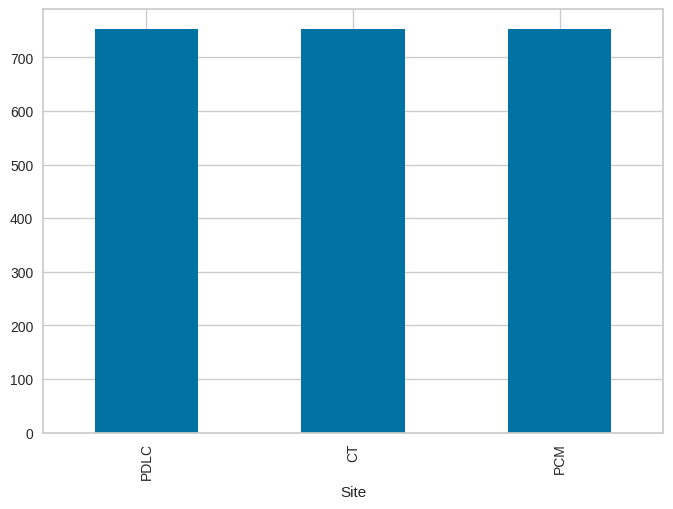

In [18]:
# oversampling strategy
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

y_smote.value_counts().plot(kind='bar')
#plt.savefig('SMOTE_distribution.png',dpi=200, bbox_inches='tight')
y_smote.value_counts()

#### We have created a balanced synthetic data set with 752 cases per class.

In [19]:
# Creating final resampled dataset
smote_data = X_smote
smote_data['Site'] = y_smote

In [20]:
# Final dataset shape after resampling
smote_data.shape
smote_data.to_excel('./data/final_resampled_data.xlsx')
smote_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 46 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Al      2256 non-null   float64
 1   Si      2256 non-null   float64
 2   P       2256 non-null   float64
 3   S       2256 non-null   float64
 4   Cl      2256 non-null   float64
 5   K       2256 non-null   float64
 6   Ca      2256 non-null   float64
 7   Sc      2256 non-null   float64
 8   Ti      2256 non-null   float64
 9   V       2256 non-null   float64
 10  Cr      2256 non-null   float64
 11  Mn      2256 non-null   float64
 12  Fe      2256 non-null   float64
 13  Co      2256 non-null   float64
 14  Ni      2256 non-null   float64
 15  Cu      2256 non-null   float64
 16  Zn      2256 non-null   float64
 17  Ga      2256 non-null   float64
 18  Ge      2256 non-null   float64
 19  As      2256 non-null   float64
 20  Se      2256 non-null   float64
 21  Br      2256 non-null   float64
 22  